<h2 style='color:blue'>complete step-by-step guide to create a sentiment dataset (Happy/Sad/Neutral), train an RNN (LSTM) model, save it, visualize training, and make predictions:</h2>

<h1 style='color:blue'>Step 1: Create & Save the Dataset (CSV)</h1>

In [2]:
import pandas as pd
import random

# Define example sentences per sentiment
happy_texts = [
    "I'm feeling great today!", "This is the best day ever!", "I'm so happy right now.",
    "Life is beautiful!", "I’m thrilled to share this news!", "What a wonderful surprise!",
    "Feeling joyful and blessed.", "Smiling all day long!", "So much love and laughter!",
    "The sun is shining and I’m smiling."
]

sad_texts = [
    "I'm feeling down today.", "Nothing seems to go right.", "I miss those days so much.",
    "Life feels so heavy right now.", "It’s a really tough time for me.", "I feel miserable.",
    "Tears won't stop coming.", "I just want to be alone.", "My heart feels empty.",
    "The pain is unbearable."
]

neutral_texts = [
    "The report is due tomorrow.", "I have a meeting at 10 AM.", "She owns a red bicycle.",
    "There are 12 books on the shelf.", "The event starts at noon.", "It’s just another day.",
    "We need to buy groceries.", "He is 6 feet tall.", "Water boils at 100°C.",
    "The average score was 75."
]

# Set up generation
sentiments = ["Happy", "Sad", "Neutral"]
all_data = []

for _ in range(1000):
    sentiment = random.choice(sentiments)
    if sentiment == "Happy":
        text = random.choice(happy_texts)
    elif sentiment == "Sad":
        text = random.choice(sad_texts)
    else:
        text = random.choice(neutral_texts)
    
    all_data.append({"text": text, "sentiment": sentiment})

# Create and save DataFrame
df = pd.DataFrame(all_data)
df.to_csv("sentiment_dataset_1000.csv", index=False)

print("✅ Dataset with 1000 records saved as 'sentiment_dataset_1000.csv'")


✅ Dataset with 1000 records saved as 'sentiment_dataset_1000.csv'


In [3]:
df.head()

,text,sentiment
0,There are 12 books on the shelf.,Neutral
1,What a wonderful surprise!,Happy
2,The report is due tomorrow.,Neutral
3,I miss those days so much.,Sad
4,What a wonderful surprise!,Happy


In [4]:
len(df)

1000

<h1 style='color:blue'>Step 2: Preprocess Data & Train RNN (LSTM)</h1>

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv("/kaggle/input/deep-learning-rnn-sentiment-analysis/sentiment_dataset_1000.csv")
texts = df["text"].values
labels = df["sentiment"].values

# Encode labels (Happy:0, Sad:1, Neutral:2)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Tokenize text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=50)  # Pad to 50 words



2025-07-30 18:26:04.440248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753899964.689412      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753899964.762853      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h1 style='color:blue'>LO2 Starts Here</h1>

In [6]:

from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

<h1 style='color:blue'>Build RNN Network Architecture</h1>

In [7]:

# Build RNN model with regularization
model = Sequential([
    Embedding(input_dim=5000, output_dim=32, input_length=50),
    Dropout(0.2),  # Add dropout to embedding layer
    LSTM(64, kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.5),  # Add dropout to LSTM layer
    Dense(3, activation="softmax")  # 3 classes
])

model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, 
                   epochs=20, 
                   batch_size=8,
                   validation_data=(X_val, y_val),
                   callbacks=[early_stop])

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Print final training accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Check for overfitting
if train_acc - test_acc > 0.1:
    print("\nWarning: Potential overfitting detected (large gap between training and test accuracy)")
else:
    print("\nGood: No significant overfitting detected")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-07-30 18:26:20.079167: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4724 - loss: 1.4678 - val_accuracy: 0.8000 - val_loss: 0.9415
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9027 - loss: 0.6506 - val_accuracy: 0.9667 - val_loss: 0.2992
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9808 - loss: 0.3072 - val_accuracy: 1.0000 - val_loss: 0.1563
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9982 - loss: 0.1560 - val_accuracy: 1.0000 - val_loss: 0.1073
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9954 - loss: 0.1074 - val_accuracy: 1.0000 - val_loss: 0.0736
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9986 - loss: 0.0784 - val_accuracy: 1.0000 - val_loss: 0.0558
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.0609 - val_accuracy: 1.0000 - val_loss: 0.0428
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.0492 - val_accuracy: 1.0000 - val_loss: 0.

<h1 style='color:blue'>Traing Curves</h1>

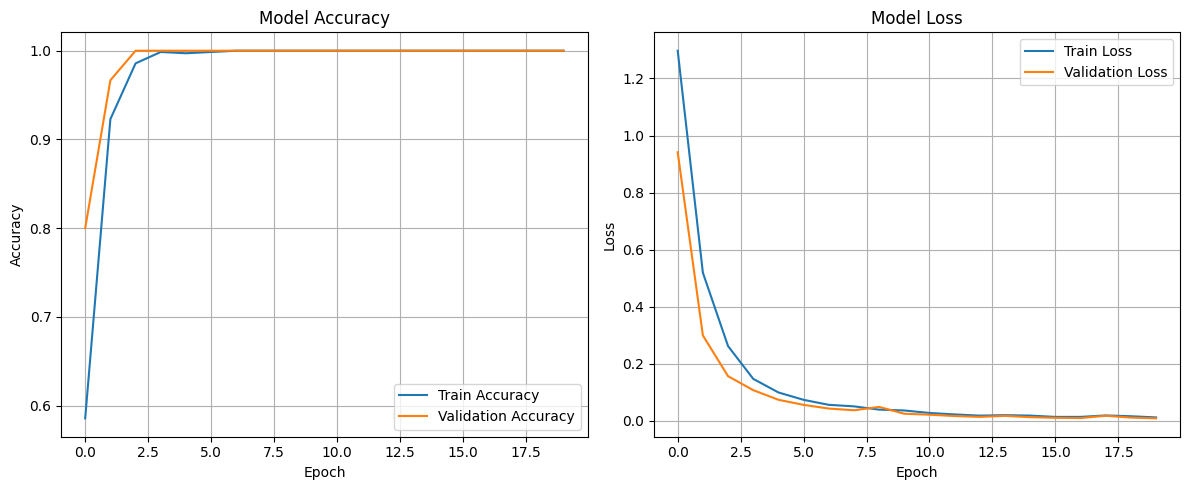

In [8]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Plot accuracy curves
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

<h1 style='color:blue'>Model Results Interpretation</h1>

In [9]:
import numpy as np

# First generate predictions for the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Print some example predictions with proper text display
print("\nExample Predictions from Test Set:")
print("{:<50} {:<10} {:<10} {:<10}".format(
    "Text", "Actual", "Predicted", "Confidence"))
print("-" * 80)

# Get the original texts for the test set
test_indices = []  # We'll store the original dataframe indices of our test set
for seq in X_test:
    # Find which original sequence matches this test sequence
    for i, original_seq in enumerate(X):
        if np.array_equal(seq, original_seq):
            test_indices.append(i)
            break

num_examples = 5
indices = np.random.choice(len(X_test), num_examples, replace=False)

for i in indices:
    # Get the original text from dataframe using the stored index
    original_text = df.iloc[test_indices[i]]['text']
    
    actual = label_encoder.inverse_transform([y_test[i]])[0]
    predicted = label_encoder.inverse_transform([y_pred_classes[i]])[0]
    confidence = np.max(y_pred[i])
    
    # Truncate long texts for better display
    display_text = (original_text[:47] + '...') if len(original_text) > 50 else original_text
    
    print("{:<50} {:<10} {:<10} {:<10.2f}".format(
        display_text, actual, predicted, confidence))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

Example Predictions from Test Set:
Text                                               Actual     Predicted  Confidence
--------------------------------------------------------------------------------
I'm so happy right now.                            Happy      Happy      1.00      
Smiling all day long!                              Happy      Happy      1.00      
The event starts at noon.                          Neutral    Neutral    1.00      
It’s just another day.                             Neutral    Neutral    1.00      
He is 6 feet tall.                                 Neutral    Neutral    1.00      


<h1 style='color:blue'>LO2 Stops Here</h1>

<h1 style='color:blue'>Step 3: Save Model & Tokenizer</h1>

In [10]:
import pickle  # Add this import at the top

# Save the model and tokenizer
model.save("sentiment_rnn.h5")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

<h1 style='color:blue'>Step 4: Plot Training Curves</h1>

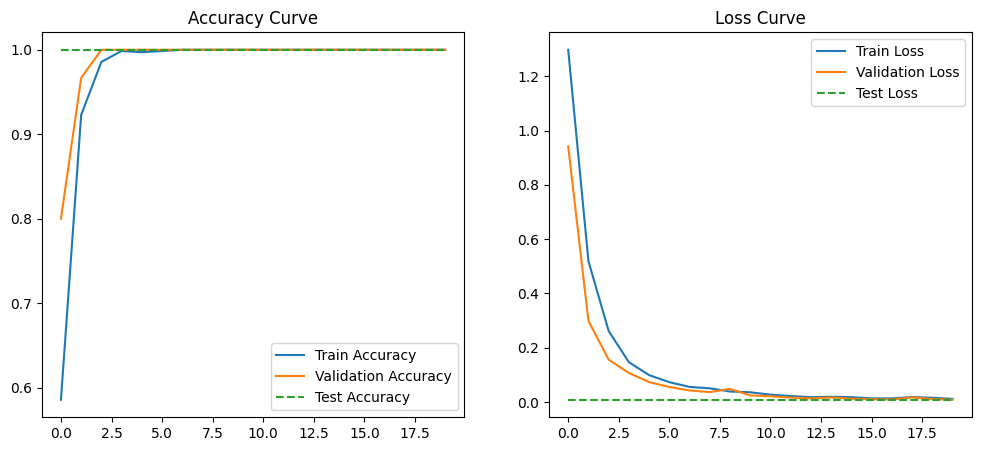

In [11]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot([test_acc]*len(history.history["accuracy"]), '--', label="Test Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot([test_loss]*len(history.history["loss"]), '--', label="Test Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

<h1 style='color:blue'>Step 5: Make Predictions on New Data</h1>

In [12]:
# Make predictions on new data
new_texts = [
    "I'm feeling great today!",
    "My dog passed away...",
    "The office is closed tomorrow."
]

# Preprocess
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=50)

# Predict
predictions = model.predict(new_padded)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

print("\nPredictions on new texts:")
for text, label in zip(new_texts, predicted_labels):
    print(f"Text: '{text}' → Sentiment: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Predictions on new texts:
Text: 'I'm feeling great today!' → Sentiment: Happy
Text: 'My dog passed away...' → Sentiment: Sad
Text: 'The office is closed tomorrow.' → Sentiment: Neutral


<h1 style="color:blue"><a href="https://huggingface.co/spaces/ntam0001/deep_learning_rnn">Click Me for Model Deployed</a></h1>